# Visualization of Activator Panel Data

This notebook uses the processed data outputs from the hexosaminidase and LDH assay analysis notebooks to generate bar graphs representing the activity of each activator in a panel. It is useful for experiments that test a single dose of many activators in both HMC1.2 and RBL-2H3, and for identifying any non-toxic degranulation inducers that may exist.

### Inputs
The input data for this notebook are processed hexosaminidase (`hmc_hex_data_filename` and `rbl_hex_data_filename`) and LDH (`hmc_ldh_data_filename` and `rbl_ldh_data_filename`) datafiles that are outputs of the hexosaminidase and LDH assay analysis notebooks (`hex_assay_analysis_main.ipynb` and `ldh_assay_analysis_main.ipynb`, respectively). The hexosaminidase assay file names have the suffix `_labeled` after the original raw data file name, and the LDH assay files have the suffix `_ldh_concs_filtered`.

The user also defines the hexosaminidase assay standard values `standards`, which are not plotted.

### Outputs
Input files for each cell line for a given assay are processed to produce a plot showing the induction of either degranulation or cytotoxicity by a given activator. These figures plot data for both cell lines side-by-side in different colors. Samples are listed in a standardized order to maximize interpretability.

In [1]:
import arcadia_pycolor as apc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# Import hexosaminidase assay data.

hmc_hex_data_filename = "../output_files/20250212_hex_assay/20250212_hex_assay_labeled.csv"
rbl_hex_data_filename = "../output_files/20250211_hex_assay/20250211_hex_assay_labeled.csv"

hmc_ldh_data_filename = (
    "../output_files/20250212_ldh_assay/20250212_ldh_assay_LDH_concs_filtered.csv"
)
rbl_ldh_data_filename = (
    "../output_files/20250211_ldh_assay/20250211_ldh_assay_LDH_concs_filtered.csv"
)

# enter the standard labels as a list of strings.
standards = [
    "500",
    "250",
    "125",
    "0",
]

In [3]:
hmc_hex_data = pd.read_csv(hmc_hex_data_filename)
rbl_hex_data = pd.read_csv(rbl_hex_data_filename)

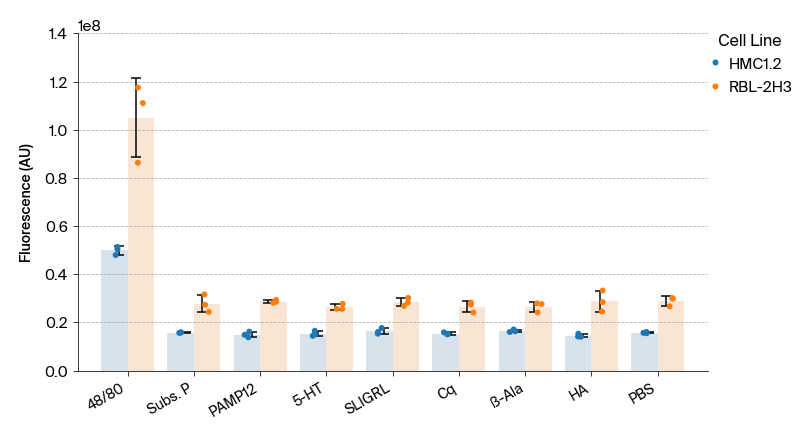

In [4]:
# Datasets must be restructured to facilitate plotting of individual replicate
# points with Seaborn.

hmc_samples_long = hmc_hex_data.melt(var_name="Sample", value_name="Fluorescence").copy()
hmc_samples_long["Cell Line"] = "HMC1.2"
hmc_samples_long["Sample"] = hmc_samples_long["Sample"].str.strip()

rbl_samples_long = rbl_hex_data.melt(var_name="Sample", value_name="Fluorescence").copy()
rbl_samples_long["Cell Line"] = "RBL-2H3"
rbl_samples_long["Sample"] = rbl_samples_long["Sample"].str.strip()

combined_samples_long = pd.concat([hmc_samples_long, rbl_samples_long], ignore_index=True)
grouped = (
    combined_samples_long.groupby(["Sample", "Cell Line"])["Fluorescence"]
    .agg(mean="mean", std="std")
    .reset_index()
)

sample_order = [
    "48/80",
    "Subs. P",
    "PAMP12",
    "5-HT",
    "SLIGRL",
    "Cq",
    "ß-Ala",
    "HA",
    "PBS",
]  # Standardized sample order.

apc.mpl.setup()
plt.figure(figsize=(10, 6))

# Plot individual replicates as dots with different colors for each cell line.
strip = sns.stripplot(
    data=combined_samples_long,
    x="Sample",
    y="Fluorescence",
    hue="Cell Line",
    jitter=True,
    size=6,
    dodge=True,
    order=(
        sample_order
        if all(item in combined_samples_long["Sample"].unique() for item in sample_order)
        else None
    ),
    palette=["#1f77b4", "#ff7f0e"],
)

# Plot bars at mean values.
sns.barplot(
    data=grouped,
    x="Sample",
    y="mean",
    hue="Cell Line",
    order=(
        sample_order
        if all(item in combined_samples_long["Sample"].unique() for item in sample_order)
        else None
    ),
    errorbar=None,
    alpha=0.2,
    dodge=True,
    palette=["#1f77b4", "#ff7f0e"],
    legend=False,
)

# Add error bars manually.
for i, sample in enumerate(sample_order):
    for j, cell_line in enumerate(["HMC1.2", "RBL-2H3"]):
        subset = grouped[(grouped["Sample"] == sample) & (grouped["Cell Line"] == cell_line)]
        if not subset.empty:
            plt.errorbar(
                x=i + (j - 0.5) * 0.25,
                y=subset["mean"],
                yerr=subset["std"],
                fmt="none",
                capsize=5,
                elinewidth=1.5,
                capthick=1.5,
                color="black",
            )

plt.xlabel("")
plt.ylabel("Fluorescence (AU)", fontsize=14)
plt.xticks(rotation=30, ha="right", fontsize=14)
plt.ylim(0, 1.4e8)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=1.0)

handles, labels = strip.get_legend_handles_labels()
plt.legend(handles, labels, title="Cell Line", loc="upper left", bbox_to_anchor=(1, 1))

output_path = (
    "/".join(hmc_hex_data_filename.split("/")[:3]) + "/pruritogen_panel_hex_superimposed.svg"
)
plt.savefig(output_path, dpi=300, bbox_inches="tight", pad_inches=0.2, format="svg")
plt.show()

In [5]:
hmc_ldh_data = pd.read_csv(hmc_ldh_data_filename)
rbl_ldh_data = pd.read_csv(rbl_ldh_data_filename)

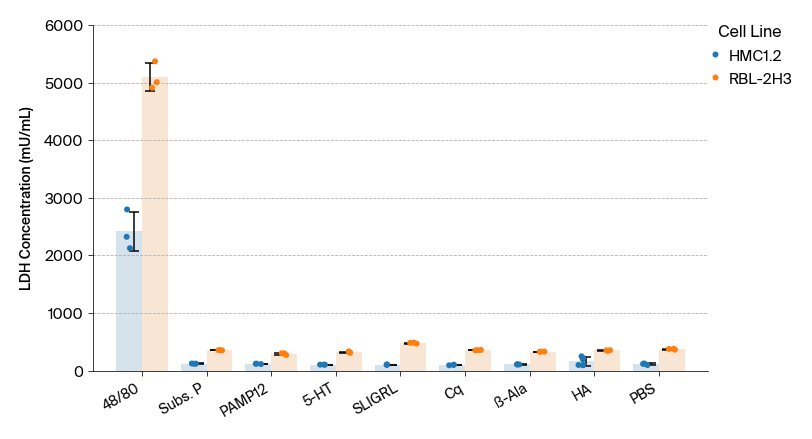

In [6]:
hmc_samples_long = hmc_ldh_data[["Sample", "LDH"]].copy()
hmc_samples_long["Sample"] = hmc_samples_long["Sample"].str.strip()
hmc_samples_long["Cell Line"] = "HMC1.2"

rbl_samples_long = rbl_ldh_data[["Sample", "LDH"]].copy()
rbl_samples_long["Sample"] = rbl_samples_long["Sample"].str.strip()
rbl_samples_long["Cell Line"] = "RBL-2H3"

combined_samples_long = pd.concat([hmc_samples_long, rbl_samples_long], ignore_index=True)
grouped = (
    combined_samples_long.groupby(["Sample", "Cell Line"])["LDH"]
    .agg(mean="mean", std="std")
    .reset_index()
)

plt.figure(figsize=(10, 6))

# Plot individual replicates as dots with different colors for each cell line.
strip = sns.stripplot(
    data=combined_samples_long,
    x="Sample",
    y="LDH",
    hue="Cell Line",
    jitter=True,
    size=6,
    dodge=True,
    order=(
        sample_order
        if all(item in combined_samples_long["Sample"].unique() for item in sample_order)
        else None
    ),
    palette=["#1f77b4", "#ff7f0e"],
)

# Plot bars at mean values.
sns.barplot(
    data=grouped,
    x="Sample",
    y="mean",
    hue="Cell Line",
    order=(
        sample_order
        if all(item in combined_samples_long["Sample"].unique() for item in sample_order)
        else None
    ),
    errorbar=None,
    alpha=0.2,
    dodge=True,
    palette=["#1f77b4", "#ff7f0e"],
    legend=False,
)

# Add error bars manually.
for i, sample in enumerate(sample_order):
    for j, cell_line in enumerate(["HMC1.2", "RBL-2H3"]):
        subset = grouped[(grouped["Sample"] == sample) & (grouped["Cell Line"] == cell_line)]
        if not subset.empty:
            plt.errorbar(
                x=i + (j - 0.5) * 0.25,
                y=subset["mean"],
                yerr=subset["std"],
                fmt="none",
                capsize=5,
                elinewidth=1.5,
                capthick=1.5,
                color="black",
            )

plt.xlabel("")
plt.ylabel("LDH Concentration (mU/mL)", fontsize=14)
plt.xticks(rotation=30, ha="right", fontsize=14)
plt.ylim(0, 6000)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=1.0)

handles, labels = strip.get_legend_handles_labels()
plt.legend(handles, labels, title="Cell Line", loc="upper left", bbox_to_anchor=(1, 1))

plt.savefig(
    "/".join(hmc_ldh_data_filename.split("/")[:3]) + "/pruritogen_panel_ldh_superimposed.svg",
    dpi=300,
    bbox_inches="tight",
    pad_inches=0.2,
    format="svg",
)

plt.show()

In [7]:
import sys

loaded_modules = {
    name: mod.__version__ for name, mod in sys.modules.items() if hasattr(mod, "__version__")
}
print(loaded_modules)

{'re': '2.2.1', 'ipaddress': '1.0', 'ipykernel._version': '6.29.5', 'json': '2.0.9', 'jupyter_client._version': '8.6.3', 'platform': '1.0.8', 'zmq.sugar.version': '26.2.1', 'zmq.sugar': '26.2.1', 'zmq': '26.2.1', 'logging': '0.5.1.2', 'traitlets._version': '5.14.3', 'traitlets': '5.14.3', 'jupyter_core.version': '5.7.2', 'jupyter_core': '5.7.2', 'zlib': '1.0', '_curses': b'2.2', 'socketserver': '0.4', 'argparse': '1.1', 'dateutil._version': '2.9.0.post0', 'dateutil': '2.9.0.post0', 'six': '1.17.0', '_decimal': '1.70', 'decimal': '1.70', 'platformdirs.version': '4.3.6', 'platformdirs': '4.3.6', '_csv': '1.0', 'csv': '1.0', 'jupyter_client': '8.6.3', 'ipykernel': '6.29.5', 'IPython.core.release': '8.32.0', 'executing.version': '2.1.0', 'executing': '2.1.0', 'pure_eval.version': '0.2.3', 'pure_eval': '0.2.3', 'stack_data.version': '0.6.3', 'stack_data': '0.6.3', 'pygments': '2.19.1', 'pickleshare': '0.7.5', 'decorator': '5.1.1', 'wcwidth': '0.2.13', 'prompt_toolkit': '3.0.50', 'parso': '0